# **Расчет KL-дивергенции между группами ролей LLM (Persona-Hub)**

### **Описание:**

Задавая дополнительный condition для LLM в виде роли промптом, меняется выходное вероятностное распределение на последовательностях ответов модели.

Формула: p_t(x) = p(x|t), где t - промт.

В качестве датасета взяты данные с подходом из статьи [Scaling Synthetic Data Creation with 1,000,000,000 Personas](https://arxiv.org/abs/2406.20094v1). Датасет [PersonaHub](https://huggingface.co/datasets/proj-persona/PersonaHub) представляет из себя сабсеты текстов на разные доменные темы, включая math, npc, knowledge, tool, reasoning и т.д.

В данном анализе для построения KL-дивергенции использовался сабсет instruction со значениями:
- **input persona**: это кондишен роли в модели,
- **synthesized text**: ответ модели,
- **description**.

### **Стояли следующие задачи:**

1) Для сравнения распределений выходов моделей, необходимо сделать кластеризацию, чтобы получить K ответов для роли (кластерная центроида роли - более общая тема). Будем использовать подходы с HDBSCAN для кластеризации текстов и UMAP для понижения размерности.

В persona-hub они делали расширение датасета по тематичным ролям, в одном распределении (больница -> медсестра -> больной). Поэтому необходимо реализовать реверс формат.

2) Мы хотим отделить персону от ее задач и дополнительных описаний - для этого будем брать первые 5 слов в роли.

3) Получение эмбеддингов текстов с помощью BERT-based и TFiDF.

4) Реализация взвешенной KL-дивергенции между двумя многомерными нормальными распределениями.

### **Пайплайн:**

- Сначала делаем кластеризацию и смотрим в понижении размерности на кластеры

- Далее считаем матрицу отношений kl-div (аппроксимируем распределение для каждой роли -> взвешенное kl) - E_p log p/q \approx sum_k log p_k / log q_k

In [2]:
!pip install umap-learn
!pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.9 MB/s eta 0:00:00
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.10
    Uninstalling Cython-3.0.10:
      Successfully uninstalled Cython-3.0.10


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from transformers import DistilBertTokenizer, DistilBertModel
from scipy.stats import multivariate_normal
from scipy.special import kl_div
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from umap import UMAP
import hdbscan
from transformers import DistilBertTokenizer, DistilBertModel

### Загруза Persona-hub датасета с 50k семплов

In [4]:
df = pd.read_json("hf://datasets/proj-persona/PersonaHub/instruction.jsonl", lines=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
df = df[:500]
df

,input persona,synthesized text,description
0,A theater manager or events coordinator intere...,What are the key considerations for scheduling...,2-shot instruction data synthesis
1,An urban planner looking to understand the dis...,Compare and contrast the distribution of publi...,2-shot instruction data synthesis
2,A high school literature teacher looking for s...,Can you provide me with a list of 5-7 educatio...,0-shot instruction data synthesis
3,"A science fiction writer, exploring the use of...","In a dystopian future, a young journalist name...",2-shot instruction data synthesis
4,A financial analyst specializing in Asian mark...,Gerald Chan's investment firm has recently acq...,2-shot instruction data synthesis
...,...,...,...
495,A real estate investor looking for potential o...,Can you provide a list of post-conflict region...,0-shot instruction data synthesis
496,A track and field coach specializing in hurdle...,Can you help me analyze the performance data o...,0-shot instruction data synthesis
497,A fitness trainer who enjoys incorporating div...,Create a 45-minute high-intensity interval tra...,0-shot instruction data synthesis
498,"A high school Gaelic football coach, aiming to...",List of famous Gaelic football players or insp...,2-shot instruction data synthesis


### Разделение input_persona на persona и condition путем выделения первых 5 слов из описания

In [6]:
def split_input(input_string):
    words = input_string.split()
    persona = ' '.join(words[:5])  # First 5 words
    condition = ' '.join(words[5:])  # Remaining words
    return persona, condition

df['persona'], df['condition'] = zip(*df['input persona'].apply(split_input))
df.head()

,input persona,synthesized text,description,persona,condition
0,A theater manager or events coordinator intere...,What are the key considerations for scheduling...,2-shot instruction data synthesis,A theater manager or events,coordinator interested in understanding the op...
1,An urban planner looking to understand the dis...,Compare and contrast the distribution of publi...,2-shot instruction data synthesis,An urban planner looking to,understand the distribution and organization o...
2,A high school literature teacher looking for s...,Can you provide me with a list of 5-7 educatio...,0-shot instruction data synthesis,A high school literature teacher,looking for supplementary materials to enrich ...
3,"A science fiction writer, exploring the use of...","In a dystopian future, a young journalist name...",2-shot instruction data synthesis,"A science fiction writer, exploring",the use of secret trials as a theme in stories...
4,A financial analyst specializing in Asian mark...,Gerald Chan's investment firm has recently acq...,2-shot instruction data synthesis,A financial analyst specializing in,"Asian markets and wealthy individuals, interes..."


In [7]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

def get_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    # Получение эмбеддингов
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].numpy()  # Берем только [CLS] токен

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

### Применяем HDBSCAN и UMAP для кластеризации и понижения размерности на input_persona, persona и condition

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


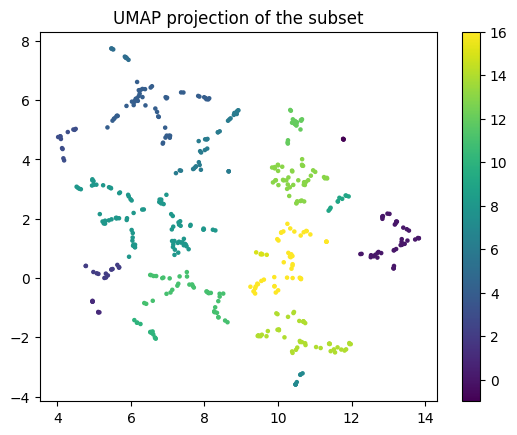

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


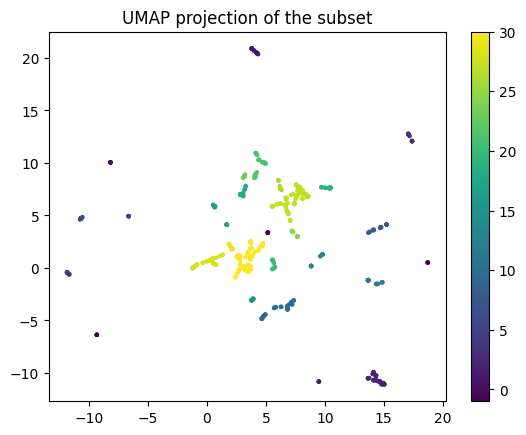

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


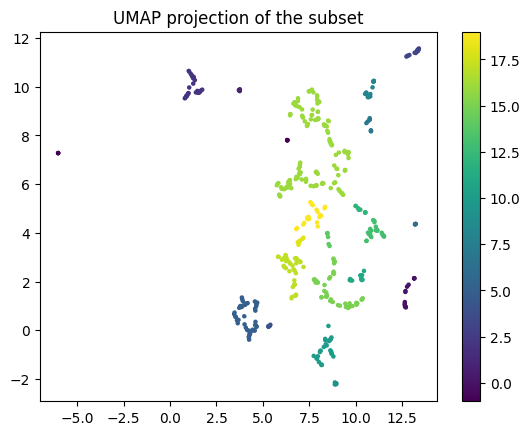

In [8]:
def process_and_cluster(data):
    embeddings = np.vstack(data.apply(get_embeddings))
    embeddings = normalize(embeddings)  # Нормализация для улучшения кластеризации

    # UMAP
    umap = UMAP(n_neighbors=3, min_dist=0.0, n_components=2, random_state=42)
    data_umap = umap.fit_transform(embeddings)

    # HDBSCAN
    clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1, cluster_selection_epsilon=0.5)
    labels = clusterer.fit_predict(data_umap)

    # Визуализация
    plt.scatter(data_umap[:, 0], data_umap[:, 1], c=labels, cmap='viridis', s=5)
    plt.colorbar()
    plt.title('UMAP projection of the subset')
    plt.show()

    return labels, data_umap

for column in ['condition', 'persona', 'input persona']:
    df[f'{column}_cluster'], projections = process_and_cluster(df[column])
    new_df = df[[column, f'{column}_cluster', 'synthesized text']]
    new_df.to_csv(f'{column}_clusters.csv', index=False)  # результат в CSV

In [64]:
df

,input persona,synthesized text,description,persona,condition,condition_cluster,persona_cluster,input persona_cluster
0,A theater manager or events coordinator intere...,What are the key considerations for scheduling...,2-shot instruction data synthesis,A theater manager or events,coordinator interested in understanding the op...,14,2,0
1,An urban planner looking to understand the dis...,Compare and contrast the distribution of publi...,2-shot instruction data synthesis,An urban planner looking to,understand the distribution and organization o...,14,0,16
2,A high school literature teacher looking for s...,Can you provide me with a list of 5-7 educatio...,0-shot instruction data synthesis,A high school literature teacher,looking for supplementary materials to enrich ...,4,3,5
3,"A science fiction writer, exploring the use of...","In a dystopian future, a young journalist name...",2-shot instruction data synthesis,"A science fiction writer, exploring",the use of secret trials as a theme in stories...,16,30,1
4,A financial analyst specializing in Asian mark...,Gerald Chan's investment firm has recently acq...,2-shot instruction data synthesis,A financial analyst specializing in,"Asian markets and wealthy individuals, interes...",6,29,15
...,...,...,...,...,...,...,...,...
495,A real estate investor looking for potential o...,Can you provide a list of post-conflict region...,0-shot instruction data synthesis,A real estate investor looking,for potential opportunities in post-conflict r...,11,30,13
496,A track and field coach specializing in hurdle...,Can you help me analyze the performance data o...,0-shot instruction data synthesis,A track and field coach,"specializing in hurdles events, looking to ana...",0,5,9
497,A fitness trainer who enjoys incorporating div...,Create a 45-minute high-intensity interval tra...,0-shot instruction data synthesis,A fitness trainer who enjoys,"incorporating diverse music genres, including ...",0,11,10
498,"A high school Gaelic football coach, aiming to...",List of famous Gaelic football players or insp...,2-shot instruction data synthesis,A high school Gaelic football,"coach, aiming to provide players with role mod...",0,10,10


In [65]:
df['input persona_cluster'].unique()

array([ 0, 16,  5,  1, 15,  9, -1,  3, 11, 13, 18,  2, 17, 12,  7, 19,  4,
       10, 14,  6,  8])

In [66]:
df['condition_cluster'].unique()

array([14,  4, 16,  6,  0, 13,  8, 11,  2,  9,  7,  3, -1, 10,  5,  1, 15,
       12])

In [67]:
df['persona_cluster'].unique()

array([ 2,  0,  3, 30, 29,  1, 10,  5, 25,  4, 21, 16, 22, 15,  8, 27, 31,
       23, 33,  6, 17, 28, -1, 20, 11, 32, 18, 12, 13, 24,  9, 14, 19, 26,
        7])

## Имплементация логики подсчета KL-дивергенции по кластерам

### Visualize matrix

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_kl_matrix(kl_matrix, cluster_labels):
    """
    Функция для визуализации матрицы KL-дивергенции.

    Args:
    kl_matrix (np.array): Квадратная матрица KL-дивергенции.
    cluster_labels (list): Список меток кластеров.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(kl_matrix, fmt=".2f", cmap='viridis')
    plt.title('KL Divergence Matrix')
    plt.xlabel('Cluster Q')
    plt.ylabel('Cluster P')
    plt.show()

###  Distribution Distance Metrics

In [ ]:
def dist_metrics(kl_matrix):
  kl_matrix = np.array(kl_matrix)
  non_zero_elements = kl_matrix[kl_matrix != 0]

  mean_kl_divergence = np.mean(non_zero_elements)
  max_kl_divergence = np.max(non_zero_elements)
  std_kl_divergence = np.std(non_zero_elements)

  print(f"Среднее значение KL-дивергенции: {mean_kl_divergence}")
  print(f"Максимальное значение KL-дивергенции: {max_kl_divergence}")
  print(f"Стандартное отклонение KL-дивергенции: {std_kl_divergence}")

## Подход 1. Кластеризация и параметризация распределений на tfidf-эмбеддингах

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

clusters = df[df['persona_cluster'] != -1].groupby('persona_cluster')['synthesized text'].apply(lambda x: " ".join(x)).to_dict()

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(clusters.values())
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

# Топ-7 слов из каждого кластера
top_words = {}
for i, cluster_id in enumerate(clusters.keys()):
    row = np.squeeze(tfidf_matrix[i].toarray())
    top_indices = row.argsort()[-7:][::-1]  # Indices of top 7 values
    top_features = feature_names[top_indices]
    top_words[cluster_id] = top_features

top_words

{0: array(['drama', 'class', 'school', 'illustrate', 'lesson', 'acting',
        'stars'], dtype=object),
 1: array(['including', 'european', 'root', 'extraction', 'iris', 'orris',
        'campers'], dtype=object),
 2: array(['provide', 'detailed', 'analysis', 'exploring', 'potential',
        'underlying', 'dyskinesia'], dtype=object),
 3: array(['cad', 'keyboard', 'stakeholders', 'yara', 'community', 'team',
        'urban'], dtype=object),
 4: array(['ship', 'lesson', 'students', 'compression', 'hull', 'speeds',
        'angular'], dtype=object),
 5: array(['lesson', 'financial', 'cultural', 'region', 'explores',
        'concepts', 'study'], dtype=object),
 6: array(['criminal', 'lesson', 'history', 'empire', 'justice',
        'presentation', 'school'], dtype=object),
 7: array(['female', 'feminist', 'text', 'novel', 'gothic', 'radio',
        'techniques'], dtype=object),
 8: array(['tournaments', 'football', 'players', 'significant', 'smith',
        'sport', 'rehabilitation'],

In [ ]:
# Word frequency distribution для каждого класса
word_distribution = {cluster: {word: 0 for word in words} for cluster, words in top_words.items()}

for cluster_id, text in clusters.items():
    for word in text.split():
        if word in word_distribution[cluster_id]:
            word_distribution[cluster_id][word] += 1

# Вероятности на основе частотности слов
word_probabilities = {cluster: {} for cluster in word_distribution}
for cluster, distribution in word_distribution.items():
    total_count = sum(distribution.values())
    word_probabilities[cluster] = {word: count / total_count for word, count in distribution.items() if count > 0}


# KL divergence
def kl_divergence(p, q, all_words):
    """Calculate KL divergence between two probability distributions, ensuring they align on the same set of words."""
    epsilon = 1e-10
    p_array = np.array([p.get(word, epsilon) for word in all_words])
    q_array = np.array([q.get(word, epsilon) for word in all_words])
    return np.sum(p_array * np.log(p_array / q_array))

all_words = set(word for cluster_dict in word_probabilities.values() for word in cluster_dict.keys())

clusters_ids = df[df['persona_cluster'] != -1]
clusters_ids = clusters_ids['persona_cluster'].unique()

kl_matrix = np.zeros((len(clusters_ids), len(clusters_ids)))
for i, cid_i in enumerate(clusters_ids):
    for j, cid_j in enumerate(clusters_ids):
        if i != j:
            kl_matrix[i, j] = kl_divergence(word_probabilities[cid_i], word_probabilities[cid_j], all_words)

kl_matrix

array([[ 0.        , 22.38681906, 22.38681906, 22.38681906, 22.38681906,
        22.38681906, 22.38681906, 22.38681906, 22.38681906,  5.15866181,
        22.38681906, 22.38681906, 22.38681906, 22.38681906, 22.38681906,
        22.38681906, 22.38681906, 22.38681906, 22.38681906, 22.38681906,
        22.38681906, 22.38681906, 22.38681906, 22.38681906, 22.38681906,
        22.38681906, 22.38681906, 22.38681906, 22.38681906, 22.38681906,
        22.38681906],
       [21.52106264,  0.        , 21.52106263, 21.52106264, 21.52106264,
        21.52106264, 19.45826707, 21.52106263, 21.52106264, 21.52106263,
        21.52106264, 21.52106264, 21.52106264, 21.52106263, 21.52106263,
        21.52106263, 21.52106264, 21.52106264, 15.09613873, 21.52106264,
        21.52106264, 21.52106263, 21.52106264, 21.52106264, 21.52106264,
        21.52106263, 21.52106264, 21.52106264, 21.52106264, 21.52106264,
        21.52106264],
       [21.35126136, 21.35126135,  0.        , 21.35126135, 21.35126135,
       

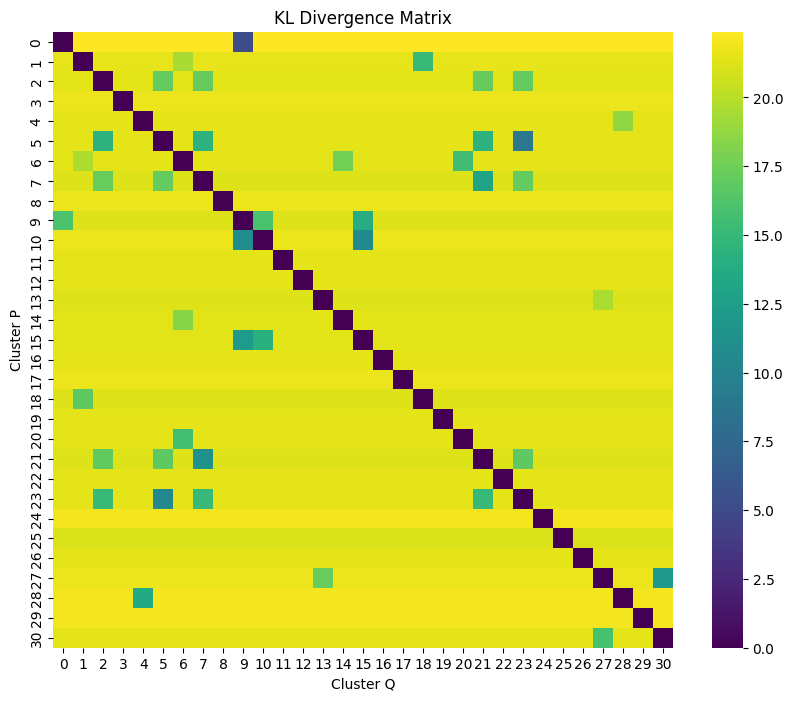

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

visualize_kl_matrix(kl_matrix, word_distribution.keys())

In [ ]:
dist_metrics(kl_matrix)

Среднее значение KL-дивергенции: 21.239472083049677
Максимальное значение KL-дивергенции: 22.38681906372673
Стандартное отклонение KL-дивергенции: 1.4920128242214066


## Подход 2. Кластеризация и параметризация распределений на Bert-эмбеддингах

In [ ]:
import numpy as np
import pandas as pd
import torch
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.preprocessing import normalize
from umap import UMAP
import hdbscan
import matplotlib.pyplot as plt
from scipy.stats import entropy, multivariate_normal

In [12]:
# Расчет эмбеддингов и кластеризация
def process_and_cluster(data):
    embeddings = np.vstack(data['synthesized text'].apply(get_embeddings))
    embeddings = normalize(embeddings)
    umap = UMAP(n_neighbors=3, min_dist=0.0, n_components=2, random_state=42)
    data_umap = umap.fit_transform(embeddings)
    clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1, cluster_selection_epsilon=0.5)
    labels = clusterer.fit_predict(data_umap)
    return labels, data_umap

In [ ]:
from IPython.display import display, Math, Markdown

text = r"""
Функция ниже вычисляет KL-дивергенцию между двумя многомерными нормальными распределениями. Формула для KL-дивергенции между двумя многомерными нормальными распределениями выглядит так:
"""

formula = r"""
D_{KL}(\mathcal{N}(\mu_1, \Sigma_1) \parallel \mathcal{N}(\mu_2, \Sigma_2)) =
\frac{1}{2} \left( \text{tr}(\Sigma_2^{-1} \Sigma_1) + (\mu_2 - \mu_1)^T \Sigma_2^{-1} (\mu_2 - \mu_1) - k + \log \left(\frac{\det \Sigma_2}{\det \Sigma_1}\right) \right)
"""

description = r"""
Где \( k \) — размерность распределений.
"""

display(Markdown(text))
display(Math(formula))
display(Markdown(description))


Функция ниже вычисляет KL-дивергенцию между двумя многомерными нормальными распределениями. Формула для KL-дивергенции между двумя многомерными нормальными распределениями выглядит так:


<IPython.core.display.Math object>


Где \( k \) — размерность распределений.


In [ ]:
def compute_kl_divergence_gaussian(data):
    clusters = data['persona_cluster'].unique()
    clusters = clusters[clusters != -1]  # Удаляем кластер-выброс
    cluster_texts = {cluster: data[data['persona_cluster'] == cluster]['synthesized text'] for cluster in clusters}
    embeddings = {cluster: np.vstack(texts.apply(get_embeddings)) for cluster, texts in cluster_texts.items()}

    # Считаем среднее и ковариацию для каждого кластера
    means = {cluster: np.mean(vec, axis=0) for cluster, vec in embeddings.items()}
    covariances = {cluster: np.cov(vec, rowvar=False) + np.eye(vec.shape[1]) * 1e-5 for cluster, vec in embeddings.items()}  # Add small noise to avoid singularity

    kl_matrix = np.zeros((len(clusters), len(clusters)))
    for i, c1 in enumerate(clusters):
        for j, c2 in enumerate(clusters):
            if i != j:
                mean1, cov1 = means[c1], covariances[c1]
                mean2, cov2 = means[c2], covariances[c2]
                kl_divergence = kl_divergence_gaussian(mean1, cov1, mean2, cov2)
                kl_matrix[i, j] = kl_divergence
            else:
                kl_matrix[i, j] = 0  # kl-div между диагольными кластерами (одинаковыми) равна 0

    return kl_matrix

def kl_divergence_gaussian(mean1, cov1, mean2, cov2):
    """Calculate the KL divergence between two multivariate Gaussians in a numerically stable way."""
    inv_cov2 = np.linalg.inv(cov2) # Вычисляем обратную матрицу для Σ2
    trace_term = np.trace(inv_cov2.dot(cov1)) # Вычисляем след произведения Σ2^-1*Σ1

    mean_diff = mean2 - mean1
    mean_term = mean_diff.T.dot(inv_cov2).dot(mean_diff) # Вычисляем разность средних значений и её вклад в KL-дивергенцию.

    log_det_cov1 = np.linalg.slogdet(cov1)[1]
    log_det_cov2 = np.linalg.slogdet(cov2)[1]
    log_det_term = log_det_cov2 - log_det_cov1 # Логарифм отношения определителей Σ2 и Σ1

    return 0.5 * (trace_term + mean_term + log_det_term - mean1.size)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


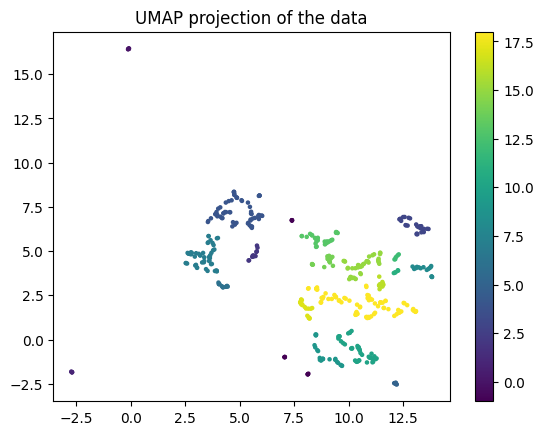

In [ ]:
def visualize_clusters(data_umap, labels):
    plt.scatter(data_umap[:, 0], data_umap[:, 1], c=labels, cmap='viridis', s=5)
    plt.colorbar()
    plt.title('UMAP projection of the data')
    plt.show()

labels, data_umap = process_and_cluster(df)
kl_matrix = compute_kl_divergence_gaussian(df)
visualize_clusters(data_umap, labels)

In [ ]:
kl_matrix

array([[      0.        ,  985194.41929555, 1132593.0101055 ,
         405373.6006097 , 1027521.7257541 ,  985492.21303392,
        1082766.83084034,  911488.38207537,  701574.9270638 ,
         379831.52099545,  829825.76781489,  963178.54225981,
         847328.6386049 ,  899593.82189383,  779397.6303427 ,
         585914.87310842,  994753.39740964, 1044506.14504392,
        1315372.4387141 , 1035950.05208443, 1121701.60203658,
        1247143.91285019, 1178536.97684453,  882016.98410675,
        1146041.41753675, 1289065.68503448,  892437.06182136,
        1023457.84584897, 1076416.61667552, 1226167.94209302,
        1174445.52765779],
       [ 688609.68379697,       0.        ,  985977.39556136,
         326033.88186329,  918038.88707331,  884835.76890437,
        1010742.94086839,  845873.86076416,  605966.73196028,
         350853.53909874,  687616.60613507,  898850.27869465,
         662990.48687412,  778815.92193418,  628840.23680185,
         524251.60743275,  858978.06236595,

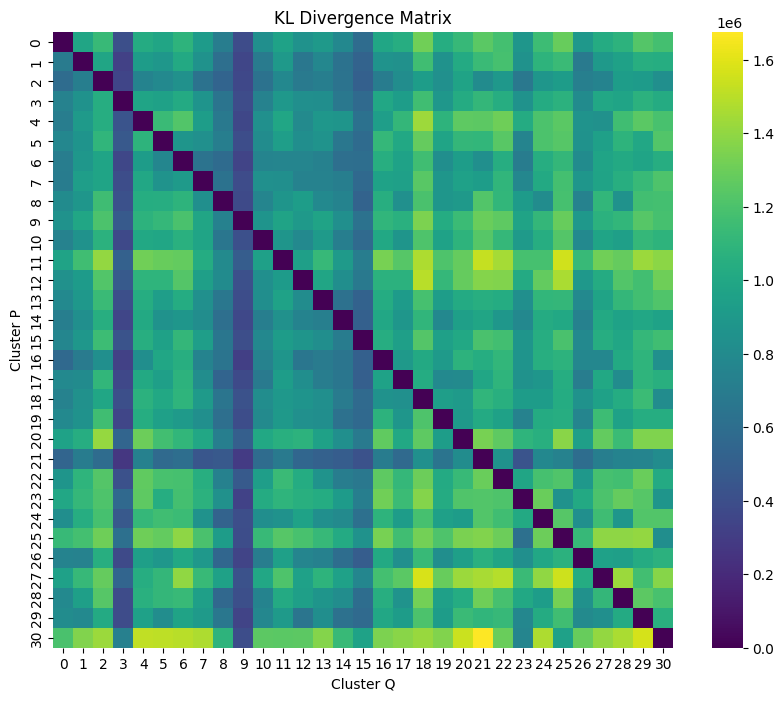

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

visualize_kl_matrix(kl_matrix, labels)

In [ ]:
df[df['persona_cluster']==9][['synthesized text', 'input persona']] # ~claster of history

,synthesized text,input persona
49,Write a comprehensive essay on the comparative...,A mythologist specializing in comparative stud...
90,Can you provide a list of historical archives ...,A genealogist researching family history with ...
107,Can you help me find information on Doña María...,"A genealogist researching family history, focu..."
186,Describe the experiences of merchant mariners ...,A genealogist researching family histories of ...
263,I'm trying to track the migration patterns of ...,A genealogist researching family histories in ...
301,Can you provide a comparative analysis of the ...,"A historian of ancient religions, studying the..."
302,"(In a dimly lit, smoke-filled temple in ancien...",A cultural anthropologist studying superstitio...
337,Analyze the historical development of telescop...,"A historian of technology, interested in the e..."
352,Analyze the significance of Nara Burnu in the ...,A military strategist examining historical bat...
415,Can you help me uncover the ancestral ties bet...,A genealogist researching the Cheyne family hi...


In [ ]:
df[df['persona_cluster']==22][['synthesized text', 'input persona']] # ~claster of engineer

,synthesized text,input persona
12,Can you help me understand the origins and reg...,A linguist with expertise in Russian language ...
79,Designing a dynamic quest system where players...,A game designer with experience in massively m...
88,A sports organization is analyzing the results...,A data analyst with interest in sports analyti...
179,Provide a Python library or framework recommen...,A quantitative analyst with expertise in finan...
209,Researching Portuguese noble families and thei...,A genealogist with expertise in tracing family...
291,Provide a detailed overview of the historical ...,A historian with a focus on the geography and ...
346,Can you assist me in developing an inclusive s...,An accessibility consultant with expertise in ...
355,Can you help me compile a list of all the one-...,A local historian or genealogist researching t...
369,Can you provide a comprehensive overview of th...,A professional librarian with expertise in aca...
428,Can you provide a detailed comparison of the o...,A sedimentary geologist with expertise in carb...


In [ ]:
df[df['persona_cluster']==30][['synthesized text', 'input persona']] # ~claster of life science

,synthesized text,input persona
10,Can you provide an overview of the role of rel...,An environmental researcher specializing in re...
32,Discuss the significance of the 1976 Winter Ol...,A sports journalist covering the history of ic...
47,Compare and contrast the health benefits of Ra...,A nutritionist specializing in plant-based die...
53,Can you provide a detailed explanation of the ...,A geologist specializing in the study of grani...
57,Can you provide a comprehensive overview of th...,A botanist interested in plant breeding and it...
...,...,...
454,EXPLORING JAPANESE POP ART: Discuss the influe...,An art history student with a focus on post-wa...
467,Can you provide a detailed breakdown of the vo...,"A journalist covering Louisiana politics, trac..."
470,Applications of computer vision in e-commerce ...,An entrepreneur in the field of graphics searc...
474,Can you provide a detailed explanation of the ...,A biochemist specializing in enzyme functions ...


Трактовать оба подхода можно следующим образом:
- различие в сути показывает более желтая карта (1 подход на ifidf),
- различие в разнообразии ответа показывает более синяя карта (2 подход на bert эмбеддингах)

## Задача (*) - пропущенные роли (выбросы)

In [9]:
df

,input persona,synthesized text,description,persona,condition,condition_cluster,persona_cluster,input persona_cluster
0,A theater manager or events coordinator intere...,What are the key considerations for scheduling...,2-shot instruction data synthesis,A theater manager or events,coordinator interested in understanding the op...,14,1,0
1,An urban planner looking to understand the dis...,Compare and contrast the distribution of publi...,2-shot instruction data synthesis,An urban planner looking to,understand the distribution and organization o...,14,3,16
2,A high school literature teacher looking for s...,Can you provide me with a list of 5-7 educatio...,0-shot instruction data synthesis,A high school literature teacher,looking for supplementary materials to enrich ...,4,5,5
3,"A science fiction writer, exploring the use of...","In a dystopian future, a young journalist name...",2-shot instruction data synthesis,"A science fiction writer, exploring",the use of secret trials as a theme in stories...,16,27,1
4,A financial analyst specializing in Asian mark...,Gerald Chan's investment firm has recently acq...,2-shot instruction data synthesis,A financial analyst specializing in,"Asian markets and wealthy individuals, interes...",6,12,15
...,...,...,...,...,...,...,...,...
495,A real estate investor looking for potential o...,Can you provide a list of post-conflict region...,0-shot instruction data synthesis,A real estate investor looking,for potential opportunities in post-conflict r...,11,27,13
496,A track and field coach specializing in hurdle...,Can you help me analyze the performance data o...,0-shot instruction data synthesis,A track and field coach,"specializing in hurdles events, looking to ana...",0,6,9
497,A fitness trainer who enjoys incorporating div...,Create a 45-minute high-intensity interval tra...,0-shot instruction data synthesis,A fitness trainer who enjoys,"incorporating diverse music genres, including ...",0,10,10
498,"A high school Gaelic football coach, aiming to...",List of famous Gaelic football players or insp...,2-shot instruction data synthesis,A high school Gaelic football,"coach, aiming to provide players with role mod...",0,11,10


In [48]:
outlier_cluster = -1
outlier_texts = df[df['persona_cluster'] == outlier_cluster]['synthesized text']
len(outlier_texts)

11

In [49]:
outlier_texts

85     How can I use the pedigree of Thrown In, a cha...
202    Imagine you're leading a discussion in your bi...
220    Can you provide some real-life examples of dif...
228    Can you provide me with the latest results fro...
232    Create a 12-week training program for 18-year-...
262    Can you provide a detailed comparison of the u...
330    I'm working on a new electropop track with a r...
383    Can you break down the key components of a suc...
399    Can you provide a step-by-step guide on how to...
426    Dissecting the Sonic Alchemy of Acid Mothers T...
438    Can you provide a detailed analysis of the vil...
Name: synthesized text, dtype: object

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def compute_kl_divergence_outliers(data):
    clusters = data['persona_cluster'].unique()
    outlier_cluster = -1  # Кластер-выброс
    clusters = clusters[clusters != outlier_cluster]  # Удаляем кластер-выброс

    cluster_texts = {cluster: data[data['persona_cluster'] == cluster]['synthesized text'] for cluster in clusters}
    outlier_texts = data[data['persona_cluster'] == outlier_cluster]['synthesized text']

    embeddings = {cluster: np.vstack(texts.apply(get_embeddings).values) for cluster, texts in cluster_texts.items()}
    outlier_embeddings = np.vstack(outlier_texts.apply(get_embeddings).values)

    # Считаем среднее и ковариацию для каждого кластера
    means = {cluster: np.mean(vec, axis=0) for cluster, vec in embeddings.items()}
    covariances = {cluster: np.cov(vec, rowvar=False) + np.eye(vec.shape[1]) * 1e-5 for cluster, vec in embeddings.items()}  # Add small noise to avoid singularity

    kl_divergences = np.zeros((len(outlier_embeddings), len(clusters)))
    for i, outlier_vec in enumerate(outlier_embeddings):
        for j, cluster in enumerate(clusters):
            mean, cov = means[cluster], covariances[cluster]
            kl_divergence = kl_divergence_gaussian(outlier_vec, np.eye(outlier_vec.size) * 1e-5, mean, cov)
            kl_divergences[i, j] = kl_divergence

    return kl_divergences, clusters

def plot_kl_divergences(kl_divergences, clusters):
    plt.figure(figsize=(10, 8))
    sns.heatmap(kl_divergences, xticklabels=clusters, yticklabels=[f'Outlier {i}' for i in range(kl_divergences.shape[0])], cmap="YlGnBu", annot=True)
    plt.title('KL Divergences between Outlier Texts and Clusters')
    plt.xlabel('Cluster')
    plt.ylabel('Outlier Text')
    plt.show()


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


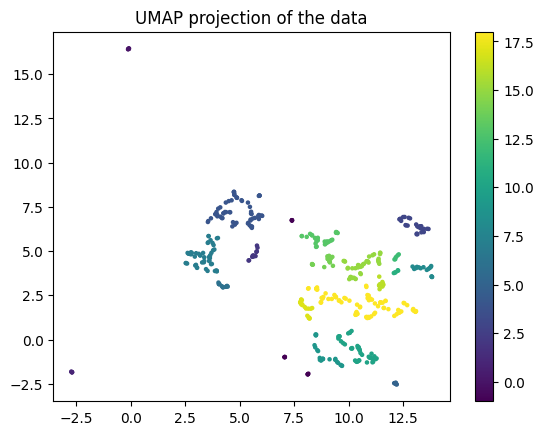

In [25]:
def visualize_clusters(data_umap, labels):
    plt.scatter(data_umap[:, 0], data_umap[:, 1], c=labels, cmap='viridis', s=5)
    plt.colorbar()
    plt.title('UMAP projection of the data')
    plt.show()

labels, data_umap = process_and_cluster(df)
kl_matrix, clusters = compute_kl_divergence_outliers(df)
visualize_clusters(data_umap, labels)

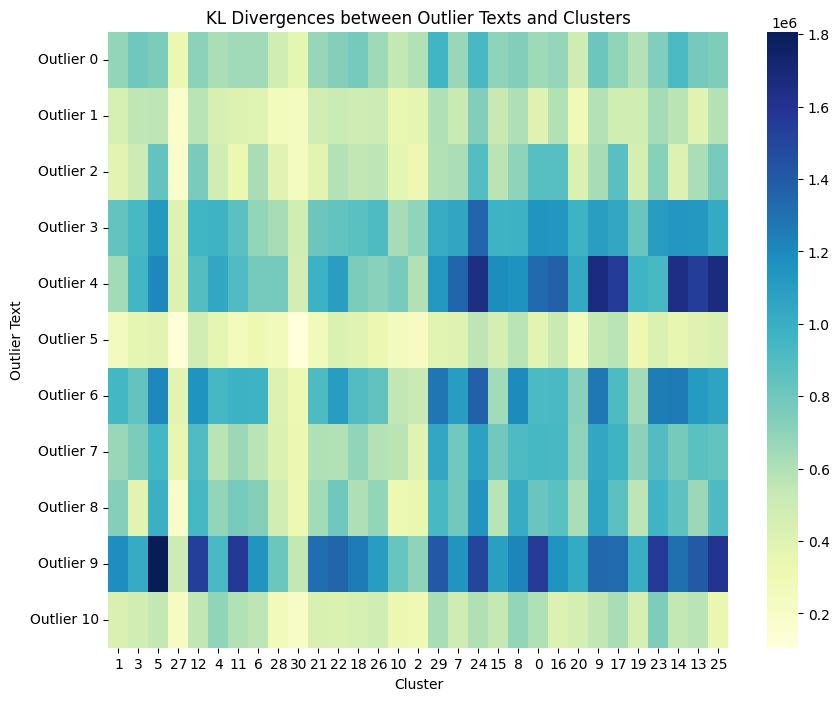

In [29]:
def plot_kl_divergences(kl_divergences, clusters):
    plt.figure(figsize=(10, 8))
    sns.heatmap(kl_divergences, xticklabels=clusters, yticklabels=[f'Outlier {i}' for i in range(kl_divergences.shape[0])], cmap="YlGnBu", annot=False)
    plt.title('KL Divergences between Outlier Texts and Clusters')
    plt.xlabel('Cluster')
    plt.ylabel('Outlier Text')
    plt.show()

plot_kl_divergences(kl_matrix, clusters)

In [59]:
outlier_texts

85     How can I use the pedigree of Thrown In, a cha...
202    Imagine you're leading a discussion in your bi...
220    Can you provide some real-life examples of dif...
228    Can you provide me with the latest results fro...
232    Create a 12-week training program for 18-year-...
262    Can you provide a detailed comparison of the u...
330    I'm working on a new electropop track with a r...
383    Can you break down the key components of a suc...
399    Can you provide a step-by-step guide on how to...
426    Dissecting the Sonic Alchemy of Acid Mothers T...
438    Can you provide a detailed analysis of the vil...
Name: synthesized text, dtype: object

In [65]:
df[df.index==426][['synthesized text', 'input persona']] # ~new role of music

,synthesized text,input persona
426,Dissecting the Sonic Alchemy of Acid Mothers T...,I'm a music producer and sound engineer with a...


In [66]:
df[df.index==232][['synthesized text', 'input persona']] # ~new role of sport training

,synthesized text,input persona
232,Create a 12-week training program for 18-year-...,A professional football coach specializing in ...


In [67]:
df[df.index==262][['synthesized text', 'input persona']] # ~new role of animal adaptation

,synthesized text,input persona
262,Can you provide a detailed comparison of the u...,A high school biology teacher who enjoys makin...


При построении кластеризации, все тексты, которые не попали по epsilon в кластер, были записаны в кластер выброса (-1), с которым мы работаем отдельно. Для того, чтобы найти новые роли, которые мы пропустили, счтаем матрицу KL-дивергенции между эмбеддингом каждого текста из -1 кластера и распределением кластеров, которые нашли выше. Из матрицы заметно, что они далеки от других ролей, но при этом генерация (энтропия) разнообразна.


In [ ]:
# import numpy as np
# import pandas as pd
# import torch
# from transformers import DistilBertTokenizer, DistilBertModel
# from sklearn.preprocessing import normalize
# from umap import UMAP
# import hdbscan
# import matplotlib.pyplot as plt
# from scipy.linalg import sqrtm

# # Вычисление статистик для каждого кластера
# def calculate_cluster_stats(data):
#     clusters = data['persona_cluster'].unique()
#     clusters = clusters[clusters != -1]  # Exclude the noise cluster if present
#     cluster_texts = {cluster: data[data['persona_cluster'] == cluster]['synthesized text'] for cluster in clusters}
#     embeddings = {cluster: np.vstack(texts.apply(get_embeddings)) for cluster, texts in cluster_texts.items()}

#     means = {cluster: np.mean(vec, axis=0) for cluster, vec in embeddings.items()}
#     covariances = {cluster: np.cov(vec, rowvar=False) + np.eye(vec.shape[1]) * 1e-5 for cluster, vec in embeddings.items()}
#     return means, covariances, list(clusters)

# # КЛ и JS дивергенции
# def kl_divergence_gaussian(mean1, cov1, mean2, cov2):
#     inv_cov2 = np.linalg.inv(cov2)
#     trace_term = np.trace(inv_cov2 @ cov1)
#     mean_diff = mean2 - mean1
#     mean_term = mean_diff.T @ inv_cov2 @ mean_diff
#     log_det_term = np.log(np.linalg.det(cov2) / np.linalg.det(cov1))
#     return 0.5 * (trace_term + mean_term + log_det_term - mean1.size)

# def js_divergence_gaussian(means, covs, i, j):
#     mean1, cov1 = means[i], covs[i]
#     mean2, cov2 = means[j], covs[j]
#     mean_m = 0.5 * (mean1 + mean2)
#     cov_m = sqrtm(0.5 * (sqrtm(cov1) @ cov2 @ sqrtm(cov1)) + np.eye(cov1.shape[0]) * 1e-10)  # Численная стабильность
#     return 0.5 * (kl_divergence_gaussian(mean1, cov1, mean_m, cov_m) + kl_divergence_gaussian(mean2, cov2, mean_m, cov_m))

# # Вычисление матриц дивергенций
# def compute_distance_metrics(means, covariances, clusters):
#     num_clusters = len(clusters)
#     kl_matrix = np.zeros((num_clusters, num_clusters))
#     js_matrix = np.zeros((num_clusters, num_clusters))

#     for i in range(num_clusters):
#         for j in range(num_clusters):
#             if i != j:
#                 kl_matrix[i, j] = kl_divergence_gaussian(means[clusters[i]], covariances[clusters[i]], means[clusters[j]], covariances[clusters[j]])
#                 js_matrix[i, j] = js_divergence_gaussian(means, covariances, clusters[i], clusters[j])
#             else:
#                 kl_matrix[i, j] = 0
#                 js_matrix[i, j] = 0

#     return kl_matrix, js_matrix

# # Пример использования
# means, covariances, clusters = calculate_cluster_stats(df)
# kl_matrix, js_matrix = compute_distance_metrics(means, covariances, clusters)
